# start

from mdl0331_5__xgb_5e5;

add hstg and domn freq features

In [1]:
PRFX='mdl0331_6_2'

trntmstmp=1584412344
valtmstmp=1585761578

tm_trn_min,tm_trn_max=(1580947200, 1581551999)
tm_val_min,tm_val_max=(1581552000, 1582156799)

SEED=101

valsz = int(10)
trnsz = int(1e6)

train_total=int(1.5e8)
test_total=int(1.4e7)
print(f'train_total {train_total:,}, test_total {test_total:,}')


import datetime
def showtm(tm): return datetime.datetime.fromtimestamp(tm).strftime('%Y-%m-%d %H:%M:%S')
print([showtm(tm) for tm in (trntmstmp, valtmstmp)])
print([showtm(tm) for tm in (tm_trn_min,tm_trn_max)])
print([showtm(tm) for tm in (tm_val_min,tm_val_max)])

train_total 150,000,000, test_total 14,000,000
['2020-03-17 02:32:24', '2020-04-01 17:19:38']
['2020-02-06 00:00:00', '2020-02-12 23:59:59']
['2020-02-13 00:00:00', '2020-02-19 23:59:59']


# setup

In [2]:
from tqdm import tqdm
import time
from pathlib import Path
from collections import Counter
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve
import pickle
import xgboost as xgb
import lightgbm as lgb
import category_encoders as ce

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)


import datetime
def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

def iou(s1,s2):
    return len(s1&s2) / len(s1|s2)

HOME='/data/git/recsys20'
p_in=f'{HOME}/input'
p_out=f'{HOME}/output/{PRFX}'
Path(p_out).mkdir(exist_ok=True, parents=True)

from sklearn.metrics import precision_recall_curve, auc, log_loss

def compute_prauc(pred, gt):
    prec, recall, thresh = precision_recall_curve(gt, pred)
    prauc = auc(recall, prec)
    return prauc

def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

cols=['toks','hshtgs','twtid','media','links','domns','twttyp','lang','tm','u1id','u1_fllwer_cnt','u1_fllwing_cnt','u1_vrfed','u1_create_tm','u2id','u2_follower_cnt','u2_following_cnt','u2_vrfed','u2_create_tm','u1_fllw_u2','reply_tm','retwt_tm','retwt_cmmnt_tm','like_tm',]

cols_val = cols[:-4]
cols_tgt_tmstmp=[ 'retwt_tm', 'reply_tm', 'like_tm', 'retwt_cmmnt_tm',]
cols_tgt=[o.split('_tm')[0] for o in cols_tgt_tmstmp]
tgts             = ['Retweet','Reply','Like','RTwCmnt',]
assert cols_tgt == ['retwt',  'reply','like','retwt_cmmnt',]
tgt2col = dict(zip(tgts, cols_tgt))
print(tgt2col)
ntgts=len(tgts)

{'Retweet': 'retwt', 'Reply': 'reply', 'Like': 'like', 'RTwCmnt': 'retwt_cmmnt'}


# prep

In [3]:
%%time
dftrn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,
                     skiprows=valsz,nrows=trnsz)

CPU times: user 6.76 s, sys: 791 ms, total: 7.55 s
Wall time: 11.5 s


In [4]:
lst_hshtgs = dftrn.hshtgs[dftrn.hshtgs.notna()].apply(lambda x: x.split('\t'))
hstgs_all = [j for i in lst_hshtgs for j in i]
hshtg2cnt = Counter(hstgs_all)
ttl=len(dftrn)
hshtg2frq = {k:v/ttl for k,v in hshtg2cnt.items()}
hshtg2cnt.most_common(10)

[('5671B8B6E92C2A316C05A7CD2F17366C', 2689),
 ('B6024D6F02AFAF9BC8ED941F72C228F1', 2551),
 ('18F6AC96A6EA62716A47DE9FE6241534', 1490),
 ('31C316EB7BB8CD1778CB83B8AA2603D9', 1132),
 ('EA152CAF6EE7894E914C522BD1B5E702', 950),
 ('746E379897167C3B81A180BF8BAADD8D', 947),
 ('E78674D323461112D0DCF8010AF5AED3', 918),
 ('F3A652C947EB7F5D093A48E95EFC62F5', 846),
 ('8420CD4576AC5373530F43B36DCA52AC', 815),
 ('F564E2BDCB9A0ABADDD4A9EE053DFCD2', 736)]

In [5]:
lst_links = dftrn.links[dftrn.links.notna()].apply(lambda x: x.split('\t'))
hstgs_all = [j for i in lst_links for j in i]
link2cnt = Counter(hstgs_all)
ttl=len(dftrn)
link2frq = {k:v/ttl for k,v in link2cnt.items()}
link2cnt.most_common(10)

[('E522B6C629B01DA6B29DE65BF5DFA55B', 240),
 ('140BCA0056E50C79778369C95D6DDC63', 103),
 ('DEA673FD63DDDC8A3606106D5CA235B0', 98),
 ('270B33AB02B6FB3F60B748CF1CB9AB75', 75),
 ('180511B4A939ADAD39FDB6604C1A9AC5', 72),
 ('4C4CB3FCFEB284BAB26F4AB727B843F9', 71),
 ('843401FA907A6D69D70FDAEDCFD5362E', 69),
 ('6DDBD9DAAA2AE38B8EBB54BA8E7098DD', 68),
 ('A00951C40B7EC9B21DFA4168B9287D39', 60),
 ('60DE00805B565526B32FF78F6EF0B9F7', 59)]

In [6]:
lst_domns = dftrn.domns[dftrn.domns.notna()].apply(lambda x: x.split('\t'))
domns_all = [j for i in lst_domns for j in i]
domn2cnt = Counter(domns_all)
ttl=len(dftrn)
domn2frq = {k:v/ttl for k,v in domn2cnt.items()}
domn2cnt.most_common(10)

[('3896E26D12C903F0A00B6B1BE9A9BEA3', 13735),
 ('E91CDEC8DC7ABF30592FA024616FF970', 8602),
 ('FECA6F2E8244F2294BD2CE957C0602A9', 6375),
 ('FCA72262B99BB78F010B25C882A0C93C', 3579),
 ('A32007FFB62B2DFC4E449BD37F985C53', 2074),
 ('9E34EBC679CA0BC677D198BEE3E37113', 1887),
 ('A898ECD422D0575A276A0D74CD01C867', 1887),
 ('BBA1D3359A23689C6783652EA73B12BA', 1419),
 ('979ECC05068307E0490EA1B9B9B44411', 1157),
 ('892B6E0BC037800B59112CFCB95E3301', 1133)]

In [7]:
twttyps=['TopLevel','Retweet','Quote']

lang2freq=dict(dftrn.lang.value_counts()/len(dftrn))
langs2feat=[k for k,v in lang2freq.items() if v>=0.01]
len(langs2feat)

11

In [8]:
def prp_tm(df, col):
    dt=pd.to_datetime(df[col], unit='s')
    df[col+'_dayofweek']=dt.dt.dayofweek
    df[col+'_hour']=dt.dt.hour

def prpdf(df,istrn=True,debug=False):
    tags = ['hshtgs','media','links','domns',]
    for tag in tags:
        df[f'has_{tag}']=df[tag].notna()
        df[tag]=df[tag].fillna('').apply(lambda x: x.split('\t') if len(x) else [])
        df[f'n_{tag}']=df[tag].apply(len)
    
    df['sum_frq_hshtg']=df['hshtgs'].apply(lambda x: sum([hshtg2frq.get(o,0) for o in x]))
    df['max_frq_hshtg']=df['hshtgs'].apply(lambda x: max([hshtg2frq.get(o,0) for o in x]) if len(x) else 0)
    df['sum_frq_domn']=df['domns'].apply(lambda x: sum([domn2frq.get(o,0) for o in x]))
    df['max_frq_domn']=df['domns'].apply(lambda x: max([domn2frq.get(o,0) for o in x]) if len(x) else 0)
        
    for m in ['Photo', 'Video', 'GIF']:
        df[f'n_media_{m}'] = df['media'].apply(lambda x: x.count(m))
    
    df['toks']=df.toks.apply(lambda x: x.split('\t'))
    df['len_toks']=df.toks.apply(len)
    
    prp_tm(df, 'tm')
    
    df['tmdlta_u2u1']  = df.u2_create_tm - df.u1_create_tm
    df['tmdlta_twtu1'] = df.tm - df.u1_create_tm
    df['tmdlta_twtu2'] = df.tm - df.u2_create_tm
    if istrn:
        df['tmleft_twt']   = tm_trn_max-df.tm
        df['tmleft_u1']    = tm_trn_max-df.u1_create_tm
        df['tmleft_u2']    = tm_trn_max-df.u2_create_tm
    else:
        df['tmleft_twt']   = tm_val_max-df.tm
        df['tmleft_u1']    = tm_val_max-df.u1_create_tm
        df['tmleft_u2']    = tm_val_max-df.u2_create_tm

    for typ in twttyps:
        df[f'twttyp_{typ}']=(df.twttyp==typ).astype('int8')

    for lang in langs2feat:
        df[f'lang_{lang}']=(df.lang==lang).astype('int8')
    
    df['u1u2']=df.u1id+'_'+df.u2id
    ce_features = ['lang', 'u1id', 'u2id', 'u1u2', 'twtid']
    cnt_encd = ce.CountEncoder()
    cnt_encded = cnt_encd.fit_transform(df[ce_features])
    cnt_encded = cnt_encded.astype(int)
    cnt_encded = cnt_encded/len(df)
    cnt_encded.columns = [f'{col}_freq' for col in ce_features]
    df = pd.concat([df,cnt_encded],1)

    if istrn: 
        df[cols_tgt]=df[cols_tgt_tmstmp].notna()
        if not debug: df.drop(inplace=True, columns=['toks','hshtgs','media','links','domns','twttyp','lang', 
                                       'tm','u1_create_tm','u2_create_tm','u1u2','u1id','u2id', 'twtid', ]+cols_tgt_tmstmp, )
    else:
        if not debug: df.drop(inplace=True, columns=['toks','hshtgs','media','links','domns','twttyp','lang', 
                                       'tm','u1_create_tm','u2_create_tm','u1u2','u1id', ])        
    return df    

In [9]:
%%time
dftrn = prpdf(dftrn)

/data/anaconda3/envs/rcss20/lib/python3.7/site-packages/category_encoders/count.py:255: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  X.loc[:, self.cols] = X.fillna(value=pd.np.nan)


CPU times: user 29.1 s, sys: 3.92 s, total: 33.1 s
Wall time: 33.1 s


In [10]:
# verify preprocess
# dftrn = prpdf(dftrn, debug=True)
# display(dftrn[['media','n_media_Photo', 'n_media_Video', 'n_media_GIF',]].sample(5))
# display(dftrn[['hshtgs','has_hshtgs', 'n_hshtgs', 'sum_frq_hshtg', 'max_frq_hshtg']].sample(5))
# display(dftrn[['domns','has_domns', 'n_domns', 'sum_frq_domn', 'max_frq_domn']].sample(5))

In [11]:
cols_feat=[o for o in dftrn.columns if o not in cols_tgt]
cols_feat

['u1_fllwer_cnt',
 'u1_fllwing_cnt',
 'u1_vrfed',
 'u2_follower_cnt',
 'u2_following_cnt',
 'u2_vrfed',
 'u1_fllw_u2',
 'has_hshtgs',
 'n_hshtgs',
 'has_media',
 'n_media',
 'has_links',
 'n_links',
 'has_domns',
 'n_domns',
 'sum_frq_hshtg',
 'max_frq_hshtg',
 'sum_frq_domn',
 'max_frq_domn',
 'n_media_Photo',
 'n_media_Video',
 'n_media_GIF',
 'len_toks',
 'tm_dayofweek',
 'tm_hour',
 'tmdlta_u2u1',
 'tmdlta_twtu1',
 'tmdlta_twtu2',
 'tmleft_twt',
 'tmleft_u1',
 'tmleft_u2',
 'twttyp_TopLevel',
 'twttyp_Retweet',
 'twttyp_Quote',
 'lang_D3164C7FBCF2565DDF915B1B3AEFB1DC',
 'lang_22C448FF81263D4BAF2A176145EE9EAD',
 'lang_06D61DCBBE938971E1EA0C38BD9B5446',
 'lang_ECED8A16BE2A5E8871FD55F4842F16B1',
 'lang_B9175601E87101A984A50F8A62A1C374',
 'lang_4DC22C3F31C5C43721E6B5815A595ED6',
 'lang_167115458A0DBDFF7E9C0C53A83BAC9B',
 'lang_125C57F4FA6D4E110983FB11B52EFD4E',
 'lang_022EC308651FACB02794A8147AEE1B78',
 'lang_FA3F382BC409C271E3D6EAF8BE4648DD',
 'lang_9BF3403E0EB7EA8A256DA9019C0B0716',


In [12]:
%%time
dfval = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=valsz)

CPU times: user 7.69 ms, sys: 0 ns, total: 7.69 ms
Wall time: 6.92 ms


In [13]:
%%time
dfval = prpdf(dfval)

CPU times: user 78.3 ms, sys: 4.79 ms, total: 83.1 ms
Wall time: 75.3 ms


# model

In [14]:
tgt2params = {k:{'objective': 'binary:logistic',
    'verbosity': 1,
    'eval_metric': [ 'aucpr','logloss',],
} for k in tgts}
tgt2res = {}


In [15]:
def train(params,dtr,dvl):
    print(params)
    evals_result = {}
    evallist = [(dtr, 'train'), (dvl, 'eval')]
    bst = xgb.train(params=params, dtrain=dtr, num_boost_round=10000, 
                    evals=evallist, evals_result=evals_result, 
                    verbose_eval=100,
                    early_stopping_rounds=100)
    return bst,evals_result

def valid(bst,dtr,dvl):
    prdtr = bst.predict(dtr, ntree_limit=bst.best_ntree_limit)
    prdvl = bst.predict(dvl, ntree_limit=bst.best_ntree_limit)
    return prdtr,prdvl


def traintgt(tgt):
    params=tgt2params[tgt]
    tgtcol=tgt2col[tgt]
    
    msk_vl=np.random.rand(len(dftrn))<0.15
    idxvl=np.where( msk_vl)[0]
    idxtr=np.where(~msk_vl)[0]
    ytr=dftrn.iloc[idxtr][tgtcol]
    yvl=dftrn.iloc[idxvl][tgtcol]
    dtr = xgb.DMatrix(dftrn.iloc[idxtr][cols_feat], label=ytr, feature_names=cols_feat)
    dvl = xgb.DMatrix(dftrn.iloc[idxvl][cols_feat], label=yvl, feature_names=cols_feat)
    bst,evals_result=train(params,dtr,dvl)
    prdtr,prdvl=valid(bst,dtr,dvl)
    return {
    'bst':bst,
    'evals_result':evals_result,
    'ytr':ytr,
    'yvl':yvl,
    'prdtr':prdtr,
    'prdvl':prdvl,
    }
    

In [16]:
for tgt in tgts:
    print(dtnow(), tgt, '*'*80)
    tmstart=time.time()
    tgt2res[tgt]=traintgt(tgt)
    print('Ran for',int((time.time()-tmstart)/60),'mins')

2020-04-02 16:57:37 Retweet ********************************************************************************
{'objective': 'binary:logistic', 'verbosity': 1, 'eval_metric': ['aucpr', 'logloss']}
[0]	train-aucpr:0.26672	train-logloss:0.53288	eval-aucpr:0.26530	eval-logloss:0.53291
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 100 rounds.
[100]	train-aucpr:0.39158	train-logloss:0.29246	eval-aucpr:0.34947	eval-logloss:0.30240
[200]	train-aucpr:0.42662	train-logloss:0.28418	eval-aucpr:0.35375	eval-logloss:0.30159
[300]	train-aucpr:0.45807	train-logloss:0.27679	eval-aucpr:0.35618	eval-logloss:0.30127
[400]	train-aucpr:0.48484	train-logloss:0.27053	eval-aucpr:0.35724	eval-logloss:0.30112
Stopping. Best iteration:
[347]	train-aucpr:0.47172	train-logloss:0.27350	eval-aucpr:0.35739	eval-logloss:0.30102

Ran for 4 mins
2020-04-02 17:02:34 Reply *************************************************************

# analyze

## tr vl

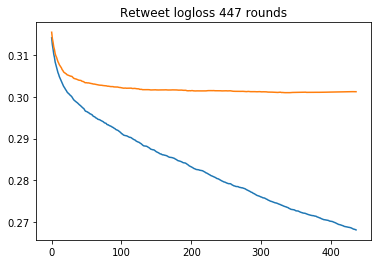

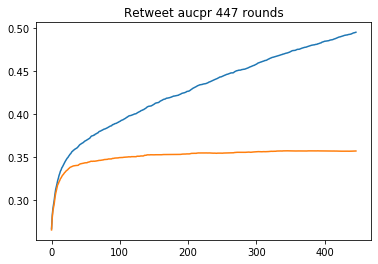

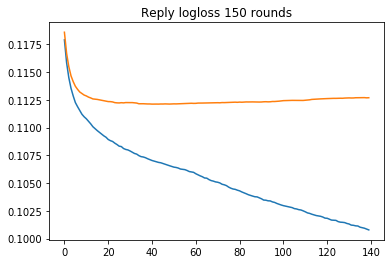

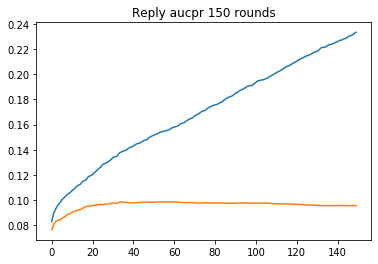

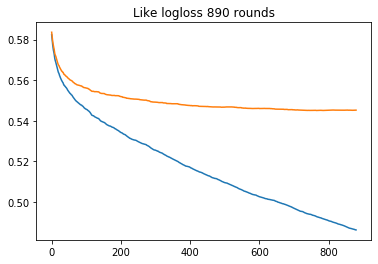

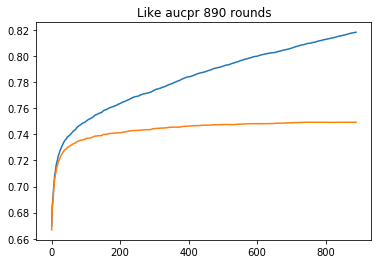

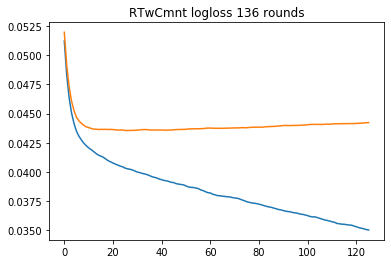

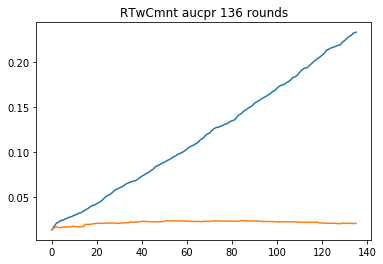

In [17]:
for tgt,res in tgt2res.items():
    evalres=res['evals_result']
    plt.plot(evalres['train']['logloss'][10:])
    plt.plot(evalres['eval']['logloss'][10:])
    plt.title(f"{tgt} logloss {len(evalres['train']['logloss'])} rounds")
    plt.show()
    plt.plot(evalres['train']['aucpr'])
    plt.plot(evalres['eval']['aucpr'])
    plt.title(f"{tgt} aucpr {len(evalres['train']['aucpr'])} rounds")
    plt.show()

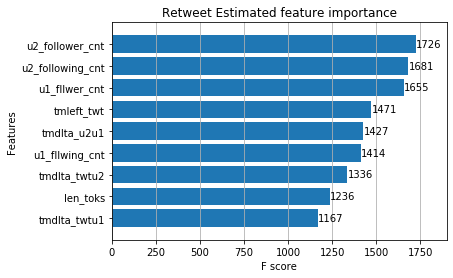

Retweet


,0,1
2,u2_follower_cnt,1726
9,u2_following_cnt,1681
13,u1_fllwer_cnt,1655
32,tmleft_twt,1471
29,tmdlta_u2u1,1427
20,u1_fllwing_cnt,1414
16,tmdlta_twtu2,1336
6,len_toks,1236
14,tmdlta_twtu1,1167
15,tmleft_u2,775


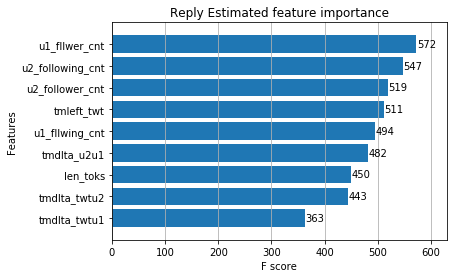

Reply


,0,1
6,u1_fllwer_cnt,572
5,u2_following_cnt,547
14,u2_follower_cnt,519
4,tmleft_twt,511
9,u1_fllwing_cnt,494
19,tmdlta_u2u1,482
17,len_toks,450
3,tmdlta_twtu2,443
12,tmdlta_twtu1,363
2,tmleft_u2,325


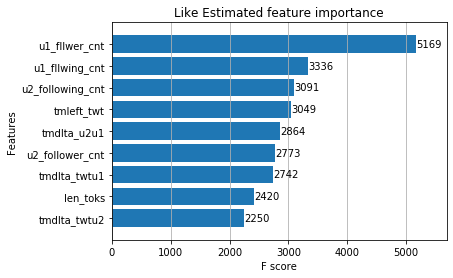

Like


,0,1
10,u1_fllwer_cnt,5169
16,u1_fllwing_cnt,3336
6,u2_following_cnt,3091
24,tmleft_twt,3049
22,tmdlta_u2u1,2864
12,u2_follower_cnt,2773
8,tmdlta_twtu1,2742
3,len_toks,2420
15,tmdlta_twtu2,2250
17,u1id_freq,1422


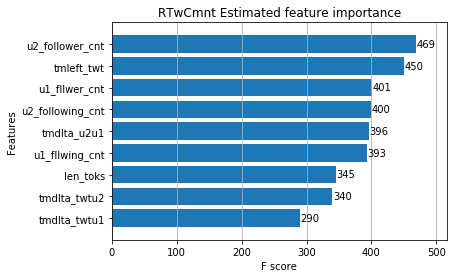

RTwCmnt


,0,1
0,u2_follower_cnt,469
18,tmleft_twt,450
3,u1_fllwer_cnt,401
15,u2_following_cnt,400
6,tmdlta_u2u1,396
9,u1_fllwing_cnt,393
10,len_toks,345
4,tmdlta_twtu2,340
8,tmdlta_twtu1,290
5,tmleft_u2,241


In [18]:
def show_feat_importance(tgt):
    bst=tgt2res[tgt]['bst']
    ax = xgb.plot_importance(bst, height=0.8, max_num_features=9)
    ax.grid(False, axis="y")
    ax.set_title(f'{tgt} Estimated feature importance')
    plt.show()
    feat2importance=bst.get_fscore()
    print(tgt)
    display(pd.DataFrame([feat2importance.keys(), 
                          feat2importance.values()]).T.sort_values(1, ascending=False))

for tgt in tgts:
    show_feat_importance(tgt)

In [19]:
for tgt in tgts:
    res=tgt2res[tgt]
    print(tgt)
    prdtr, prdvl = res['prdtr'], res['prdvl']
    ytr, yvl = res['ytr'], res['yvl']
    auc_tr=compute_prauc(prdtr, ytr)
    rce_tr=compute_rce(prdtr, ytr)
    auc_vl=compute_prauc(prdvl, yvl)
    rce_vl=compute_rce(prdvl, yvl)
    res['scrs'] = {
        'auc_tr':auc_tr,
        'rce_tr':rce_tr,
        'auc_vl':auc_vl,
        'rce_vl':rce_vl,
    }    
    print('tr prauc:', f'{auc_tr:.4f}','tr rce:', f'{rce_tr:.4f}', )
    print('vl prauc:', f'{auc_vl:.4f}','vl rce:', f'{rce_vl:.4f}', )

Retweet
tr prauc: 0.4717 tr rce: 22.5193
vl prauc: 0.3574 vl rce: 14.7688
Reply
tr prauc: 0.1515 tr rce: 15.4894
vl prauc: 0.0982 vl rce: 11.2693
Like
tr prauc: 0.8121 tr rce: 28.2570
vl prauc: 0.7493 vl rce: 20.5023
RTwCmnt
tr prauc: 0.0680 tr rce: 11.0833
vl prauc: 0.0227 vl rce: 5.1115


In [20]:
lsttr=[]
lstvl=[]
for tgt in ['Retweet','Reply','Like','RTwCmnt',]:
    res = tgt2res[tgt]
    if tgt not in tgt2res: continue
    lsttr+=[(f'PRAUC {tgt}',res['scrs']['auc_tr']),
          (f'RCE {tgt}',res['scrs']['rce_tr'])]
    lstvl+=[(f'PRAUC {tgt}',res['scrs']['auc_vl']),
          (f'RCE {tgt}',res['scrs']['rce_vl'])]

dfscrtr=pd.DataFrame(lsttr)
dfscrtr.columns=['metric','scr']
dfscrvl=pd.DataFrame(lstvl)
dfscrvl.columns=['metric','scr']
dfscr = pd.merge(dfscrtr, dfscrvl, on='metric', suffixes=('tr','vl'))
dfscr.T

,0,1,2,3,4,5,6,7
metric,PRAUC Retweet,RCE Retweet,PRAUC Reply,RCE Reply,PRAUC Like,RCE Like,PRAUC RTwCmnt,RCE RTwCmnt
scrtr,0.471718,22.5193,0.151544,15.4894,0.81209,28.257,0.0680293,11.0833
scrvl,0.357385,14.7688,0.0981546,11.2693,0.749266,20.5023,0.0226593,5.11151


# save results

In [21]:
pickle.dump(cols_feat, open(f"{p_out}/cols_feat.p", "wb"))
pickle.dump(tgt2res, open(f"{p_out}/tgt2res.p", "wb"))

# infer

In [22]:
%%time
dftst=pd.read_csv(
    f'{p_in}/val_{valtmstmp}.tsv',
    sep='\x01', header=None, names=cols_val, 
#     nrows=10
)


CPU times: user 1min 31s, sys: 8.43 s, total: 1min 39s
Wall time: 2min 35s


In [23]:
%%time
dftst = prpdf(dftst, istrn=False)

/data/anaconda3/envs/rcss20/lib/python3.7/site-packages/category_encoders/count.py:255: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  X.loc[:, self.cols] = X.fillna(value=pd.np.nan)


CPU times: user 6min 23s, sys: 1min 1s, total: 7min 25s
Wall time: 7min 24s


In [24]:
%%time
dtst = xgb.DMatrix(dftst[cols_feat], feature_names=cols_feat)
tgt2prdtst={}
for tgt in tgts:
    print(dtnow(), tgt)
    bst = tgt2res[tgt]['bst']
    prdtst = bst.predict(dtst, ntree_limit=bst.best_ntree_limit)
    tgt2prdtst[tgt] = prdtst

2020-04-02 17:27:35 Retweet
2020-04-02 17:28:12 Reply
2020-04-02 17:28:15 Like
2020-04-02 17:29:32 RTwCmnt
CPU times: user 32min 12s, sys: 21.7 s, total: 32min 34s
Wall time: 3min 13s


In [25]:
dfsub_ids = dftst[['twtid','u2id',]]

tgt2dfsub = {}
for tgt,prdtst in tgt2prdtst.items():
    dfsub = dfsub_ids.copy()
    dfsub['scr'] = prdtst
    tgt2dfsub[tgt]=dfsub

In [26]:
%%time
for i,tgt in enumerate(['Retweet','Reply','RTwCmnt','Like',]):
    dfsub = tgt2dfsub[tgt]
    print(dtnow(), tgt)
    dfsub.to_csv(f'{p_out}/{i}_{tgt}__{valtmstmp}__{PRFX}.csv',index=False,header=False)

2020-04-02 17:29:36 Retweet
2020-04-02 17:30:31 Reply
2020-04-02 17:31:27 RTwCmnt
2020-04-02 17:32:22 Like
CPU times: user 3min 28s, sys: 6.29 s, total: 3min 34s
Wall time: 3min 39s
